In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from google.colab import drive
from google.colab import files

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 로컬 파일 업로드
uploaded = files.upload()

# 업로드된 파일 이동
for filename in uploaded.keys():
    # 업로드된 파일을 구글 드라이브의 원하는 경로로 이동
    !mv "{filename}" "/content/drive/MyDrive/{filename}"

Mounted at /content/drive


Saving bs_1.csv to bs_1.csv


In [3]:
# Data load
df = pd.read_csv('/content/drive/MyDrive/bs_1.csv', encoding='cp949')
x = df.iloc[:,0:-1]
y = df.iloc[:,-1:]

In [4]:
# Training/Test ratio = 7:3
Train_ratio = 0.7
Test_ratio = 0.3

# Data Division
train_x = x.iloc[0:int(len(df)*Train_ratio),:]
train_y = y.iloc[0:int(len(df)*Train_ratio),:]
test_x = x.iloc[int(len(df)*Train_ratio):,:]
test_y = y.iloc[int(len(df)*Train_ratio):,:]

In [6]:
# Normalizing
minmax = MinMaxScaler()

train_x = minmax.fit_transform(train_x)
train_y = minmax.fit_transform(train_y)
test_x = minmax.fit_transform(test_x)
test_y = minmax.fit_transform(test_y)

# Check Data pre-processing
print("Training shape : ", train_x.shape, train_y.shape)
print("Test shape : ",test_x.shape, test_y.shape)

Training shape :  (79, 21) (79, 1)
Test shape :  (34, 21) (34, 1)


In [7]:
# Torch Variable 형태로 변경(data/grad/grad_fn)
train_x_tensor = Variable(torch.Tensor(train_x))
train_y_tensor = Variable(torch.Tensor(train_y))
test_x_tensor = Variable(torch.Tensor(test_x))
test_y_tensor = Variable(torch.Tensor(test_y))

print("After torch variable shape_Train : ",train_x_tensor.shape, train_y.shape)
print("After torch Variable shape_Test : ",test_x_tensor.shape, test_y_tensor.shape)

After torch variable shape_Train :  torch.Size([79, 21]) (79, 1)
After torch Variable shape_Test :  torch.Size([34, 21]) torch.Size([34, 1])


In [8]:
train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))
train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))
test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))
test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

print(train_x_tensor_final.shape, test_x_tensor_final.shape)

torch.Size([79, 1, 21]) torch.Size([34, 1, 21])


In [10]:
# Check GPU setting
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4

Tesla T4


In [11]:
# LSTM definition
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = train_x_tensor_final.shape[2]
hidden_size = 128
num_layers = 2
output_size = 1




model = LSTM_Model(input_size, hidden_size, num_layers, output_size)

In [12]:
# LSTM training
num_epochs = 100
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_x_tensor_final)
    optimizer.zero_grad()
    loss = criterion(outputs, train_y_tensor_final)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([79, 1, 1])) that is different to the input size (torch.Size([79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Loss: 0.3628
Epoch [11/100], Loss: 0.2184
Epoch [21/100], Loss: 0.0546
Epoch [31/100], Loss: 0.0598
Epoch [41/100], Loss: 0.0520
Epoch [51/100], Loss: 0.0472
Epoch [61/100], Loss: 0.0473
Epoch [71/100], Loss: 0.0465
Epoch [81/100], Loss: 0.0460
Epoch [91/100], Loss: 0.0458


In [13]:
# LSTM evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(test_x_tensor_final)
    test_loss = criterion(test_outputs, test_y_tensor_final)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0915


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([34, 1, 1])) that is different to the input size (torch.Size([34, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [14]:
# prediction
predicted = minmax.inverse_transform(np.concatenate((test_x, test_outputs.numpy()), axis=1))[:, -1]
actual = minmax.inverse_transform(np.concatenate((test_x, test_y.reshape(-1, 1)), axis=1))[:, -1]

In [21]:
import copy
data_combined_x = np.concatenate((train_x, test_x), axis=0)
data_combined_y = np.concatenate((train_y, test_y), axis=0)
PlotEstimated = np.empty_like(np.concatenate((data_combined_x, data_combined_y), axis=1))
PlotEstimated[:, :] = np.nan

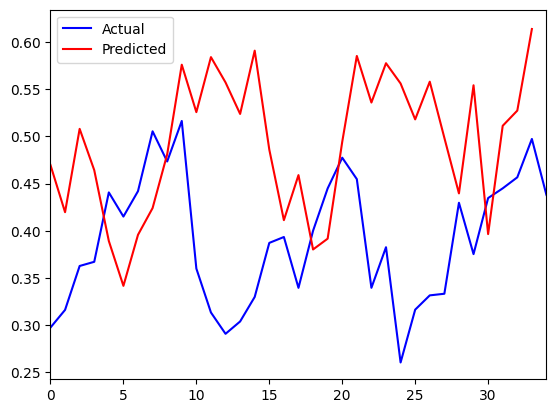

In [25]:
# Actual graph
actual_data = minmax.inverse_transform(np.concatenate((train_x_tensor_final.view(-1, input_size).cpu().numpy(), train_y_tensor_final.view(-1, 1).cpu().numpy()), axis=1))
mean_actual = actual_data.mean(axis=1)

plt.plot(mean_actual, label='Actual', color='blue')

# Predicted graph
predicted_data = minmax.inverse_transform(np.concatenate((test_x_tensor_final.view(-1, input_size).cpu().numpy(), test_outputs.view(-1, 1).cpu().numpy()), axis=1))
mean_predicted = predicted_data.mean(axis=1)

plt.plot(mean_predicted, label='Predicted', color='red')
plt.xlim(0, len(mean_predicted))

plt.legend()
plt.show()

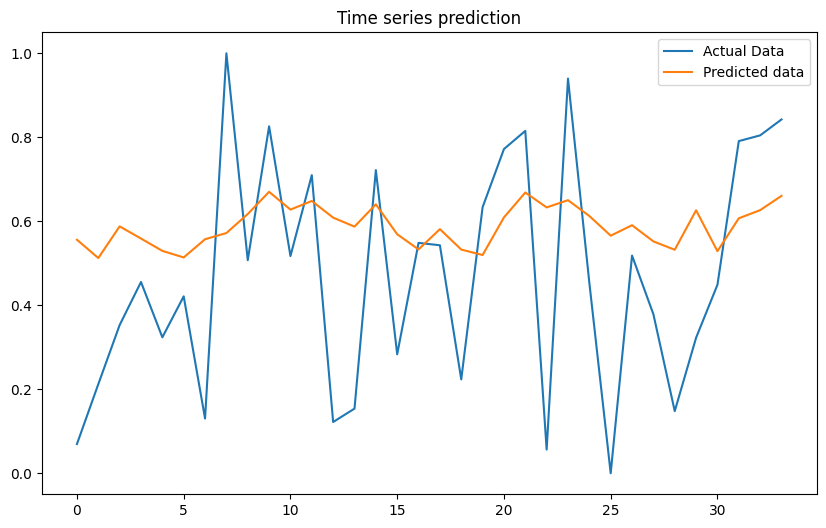

In [28]:
#Figure
plt.figure(figsize = (10,6)) # Plotting
plt.plot(actual, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()

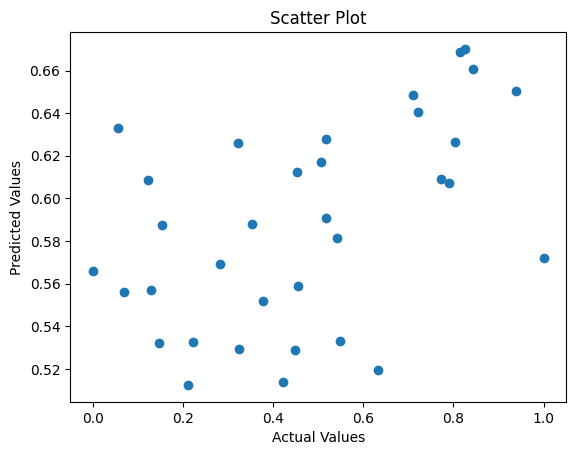

In [32]:
# 산포도 그래프 (Scatter Plot)
plt.scatter(actual, predicted)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot")
plt.show()